# Profile Based Information Retrieval System
### Carlos Alcoba, Javier Jiménez, Javier Pozo

## Install and import libraries

In [1]:
# pip install -r requirements.txt

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [2]:
#for dataframes and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

#for text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#other libraries
import random

## Import the dataset

In [3]:
from sklearn.datasets import fetch_20newsgroups

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

C:\Users\carlo\.conda\envs\PBR_22\lib\site-packages\pandas\core\arrays\datetimes.py:2199: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(


In [4]:
# Create a dataframe
data = pd.read_csv('20_newsgroup.csv', index_col = 0)

# Select only 5 classes
class_mask = data["target"].isin([7,9,13,18,19])
data = data[class_mask]
data.head()

,text,target,title,date
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,2022-04-08 14:03:50.100642
10,the blood of the lamb.\n\nThis will be a hard ...,19,talk.religion.misc,2022-04-08 14:03:50.100642
12,930418\n\nDo what thou wilt shall be the whole...,19,talk.religion.misc,2022-04-08 14:03:50.100642
40,\n\nNo. Zeno's paradox is resolved by showing...,19,talk.religion.misc,2022-04-08 14:03:50.100642
58,"\nDefinitely, J.R. ""Bob"" Dobbs, numero uno, to...",19,talk.religion.misc,2022-04-08 14:03:50.100642


In [5]:
#Split the dataset into training and testing ones
df_train, df_test = train_test_split(data,test_size=0.1,shuffle=True, random_state=1)

## Exploratory data analysis

rec.sport.baseball    905
sci.med               892
rec.autos             886
talk.politics.misc    686
talk.religion.misc    570
Name: title, dtype: int64


C:\Users\carlo\.conda\envs\PBR_22\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Number of douments in each class')]

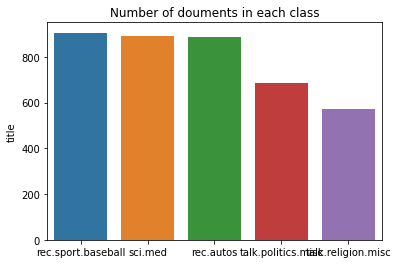

In [6]:
#Count the number of douments in each class
x=df_train['title'].value_counts()
print(x)
sns.barplot(x.index,x).set(title="Number of douments in each class")

In [7]:
# Find NaN values
df_test.isna().sum()

text      15
target     0
title      0
date       0
dtype: int64

In [8]:
# Drop NaN values
df_train = df_train.dropna()
df_test = df_test.dropna()
# Check for it
df_test.isna().sum()

text      0
target    0
title     0
date      0
dtype: int64

In [9]:
# Some word count examples
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==9]['word_count'].mean()) # Baseball posts
print(df_test[df_test['target']==9]['word_count'].mean()) # Baseball posts

129.75512528473803
116.2840909090909


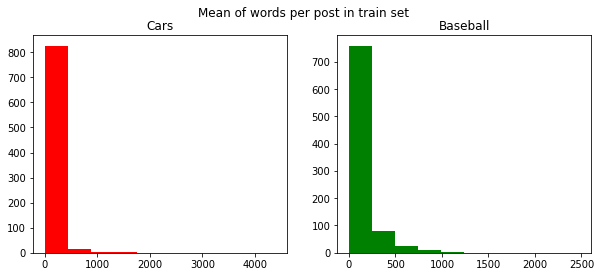

In [10]:
# Some Word-Count plots examples
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==7]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Cars')
train_words=df_train[df_train['target']==9]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Baseball')
fig.suptitle('Mean of words per post in train set')
plt.show()

In [11]:
# Some character count examplesS
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==9]['char_count'].mean()) # Baseball posts
print(df_test[df_test['target']==9]['char_count'].mean()) # Baseball posts


753.5956719817767
664.1818181818181


## Text processing

In [12]:
# Convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# Remove Stopwords
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# Lemmatize:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [13]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

# Obtain clean text columns
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x))


In [14]:
# Obtain final train and test vectors 
X_train, y_train = df_train["clean_text"], df_train["title"]
X_test, y_test = df_test["clean_text"], df_test["title"]


# Tokenize sentences to future applications
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

## Text vectorizers

In [15]:
#TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
#Obtain vectors via TF-IDF
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [16]:
# Doc2Vec vectorizer
train_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df_train.clean_text)]


#build the model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
#build vocab
model.build_vocab(train_docs)
#train model
model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)

In [17]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [18]:
# Obtain vectors via doc2vec
y_train_w2v, x_train_w2v = vec_for_learning(model, train_docs)


## Train best model found from models.ipynb

In [19]:
X_train_vectors_tfidf = X_train_vectors_tfidf.toarray()
X_test_vectors_tfidf = X_test_vectors_tfidf.toarray()

In [20]:
from keras import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [21]:
# one hot encode
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = tf.keras.utils.to_categorical(encoder.transform(y_train))
y_test = tf.keras.utils.to_categorical(encoder.transform(y_test))

In [22]:
encoder.classes_

array(['rec.autos', 'rec.sport.baseball', 'sci.med', 'talk.politics.misc',
       'talk.religion.misc'], dtype=object)

In [23]:
model = Sequential()
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.6))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
batch_size = 512
history = model.fit(X_train_vectors_tfidf, y_train,
                    epochs=20, batch_size=batch_size, validation_data=(X_test_vectors_tfidf, y_test), verbose=0)
#Predict y value for test dataset
y_predict = model.predict(X_test_vectors_tfidf)
print(classification_report(y_test.argmax(axis=1), y_predict.argmax(axis=1)))
print('Confusion Matrix:\n',confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1)))

acc = accuracy_score(y_test.argmax(axis=1), y_predict.argmax(axis=1))
f1 = f1_score(y_test.argmax(axis=1), y_predict.argmax(axis=1), average ='weighted')

print(f"Test Accuracy of Neural Network(tf-idf) is {acc} \n")

print(f"Test F1-score weighted of Neural Network(tf-idf) is {f1} \n")

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       100
           1       0.91      0.93      0.92        88
           2       0.96      0.97      0.96        95
           3       0.89      0.91      0.90        86
           4       0.85      0.76      0.80        54

    accuracy                           0.92       423
   macro avg       0.91      0.90      0.91       423
weighted avg       0.92      0.92      0.92       423

Confusion Matrix:
 [[95  1  1  2  1]
 [ 2 82  1  2  1]
 [ 0  1 92  1  1]
 [ 1  3  0 78  4]
 [ 3  3  2  5 41]]
Test Accuracy of Neural Network(tf-idf) is 0.91725768321513 

Test F1-score weighted of Neural Network(tf-idf) is 0.9164055613677237 



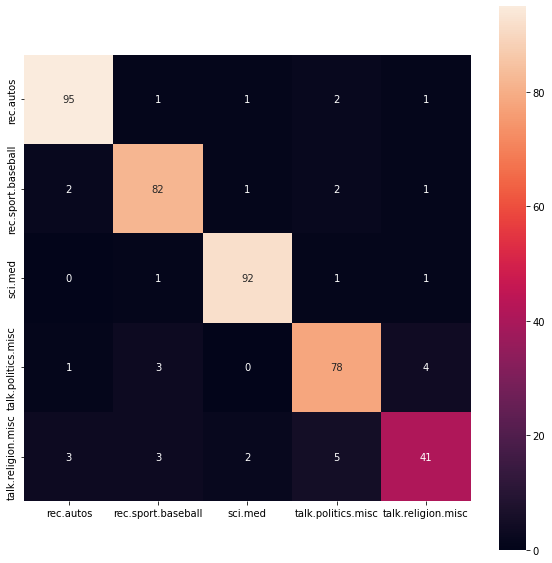

In [24]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_predict.argmax(axis=1))

plt.figure(figsize=(10,10))
sns.heatmap(matrix,annot=True, square = True, fmt='g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.savefig("confusion_matrix.jpg")
plt.show()

## Define toy set of users

In [25]:
# Associate targets with interests
interests = ["autos", "baseball", "medicine", "politics", "religion"]

def generate_users(n_user, interests= ["autos", "baseball", "medicine", "politics", "religion"]):
    users = {}
    for user in range(n_user):
        n_interest = random.randint(1, 3)
        user_interest = []
        i = random.sample(range(0,4), n_interest)
        user_interest.append([interests[e] for e in i])
            
        users[user] = user_interest
    return users

In [26]:
# Generate users
users = generate_users(10, interests=encoder.classes_)

In [27]:
# Predict the type of the query text using the best classifier
pred = model.predict(np.array( [X_test_vectors_tfidf[50],] ))
print(np.argmax(pred))


2


In [28]:
# function that automatically assigns texts for users
def assigne_text(users, pred):
    if pred == 0:
        text = 'autos'
    elif pred == 1:
        text = 'baseball'
    elif pred == 2:
        text = 'medicine'
    elif pred == 3:
        text = 'politics'
    else:
        text = 'religion'
    assigned = []
    for user, interest in users.items():
        if text[:3] in interest[0][0]:
            assigned.append(user)
            
    return assigned, text.upper()

In [29]:
assigned, text_topic = assigne_text(users, int(np.argmax(pred)))
for user in assigned:
    print("This text is assigned to user {}. It is a {} text.".format(user, text_topic))

This text is assigned to user 0. It is a MEDICINE text.
This text is assigned to user 2. It is a MEDICINE text.
This text is assigned to user 4. It is a MEDICINE text.
This text is assigned to user 6. It is a MEDICINE text.
This text is assigned to user 9. It is a MEDICINE text.
